In [34]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from support import QLAgent, make_config_txt, get_action_probabilities_as_array
import os
import pandas as pd
import os
import datetime
import scipy
import time
import matplotlib.gridspec as gridspec



### Gym Version is 0.17.0

### 1. Hyperparameters for Run

In [211]:
random_seeds = np.random.randint(low=1, high=100000, size=5000)
np.save('seeds.npy', random_seeds)

In [95]:
alphas = [0.01]
for x in range(10,1000):
    if x % 50 == 0:
        alphas.append(x/1000)
alphas.append(1)


episodes = 1500
max_steps = 200
agents_per_setting = 50


env = gym.make('Taxi-v3')
env_name = 'Taxi-v3'
gamma = 0.9
epsilon = 0.9
epsilon_min = 0.05
epsilon_decay_rate = 0.01

training_folder = ('Run2-Taxiv3-alphas') #Folder where all data will be stored
print(alphas)

[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]


### 2. Training of Agents

In [4]:
seeds = np.load('seeds.npy')
make_file_structure(training_folder, gammas, alpha, agents_per_setting, env_name, gammas, epsilon, epsilon_decay_rate, epsilon_min, episodes, max_steps)

for gamma in gammas:
    #making new folder that will hold all the agents data files
    print(f'-----------Training GAMMA: {alpha}-----------')
    for n_agent in range (1,agents_per_setting+1):
        Agent = QLAgent(env, alpha, gamma, epsilon, epsilon_decay_rate, epsilon_min, episodes, max_steps)
        return_list, reward_per_step = Agent.train()
        np.save(f'{training_folder}/agents_for_setting_{alpha}/agent_Q-Table_{n_agent}',Agent.Q)
        np.save(f'{training_folder}/agents_for_setting_{alpha}/agent_reward_per_step_{n_agent}', reward_per_step)

#Storing Date and Time of final episode to keep track of duration of one training episode and ensure completion
with open(f"{training_folder}/config.txt", "a") as file:
    file.write(f'end_of_trainingrun: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')


-----------Training ALPHA: 0.1-----------


100%|██████████| 1500/1500 [00:12<00:00, 118.01it/s]


-----------Training ALPHA: 0.11-----------


100%|██████████| 1500/1500 [00:10<00:00, 148.77it/s]


In [6]:
for alpha in alphas:
    for n_agent in range (1,agents_per_setting+1):
        Return_array = np.array([])
        Return_array = Return_array[:,np.newaxis]
        for seed in seeds:
            Return_array = np.vstack((Return_array,Agent.evaluate(seed=seed)))
        np.save(f'{training_folder}/agents_for_setting_{alpha}/agent_evaluation_return_{n_agent}', Return_array)

### 3. Statistical Analysis

#### Entropy

> - Die Base der Entropy muss die Anzahl der Klassen sein. Daher hier 6, weil wir 6 Aktionen haben im Taxi-v3

In [2]:
#making directories where figures will be saved
try: 
    os.mkdir(f'{training_folder}/figures')
except:
    pass
try:
    os.mkdir(f'{training_folder}/figures/entropy')
except:
    pass
try:
    os.mkdir(f'{training_folder}/temp')
except:
    pass

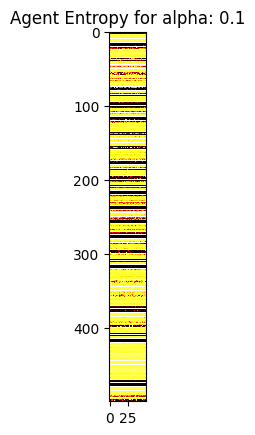

In [126]:
alpha = 0.1

agent_entropy_array = np.empty([500,0])


for n_agent in range(1,agents_per_setting +1):
    Q_table = np.load(f'{training_folder}/agents_for_setting_{alpha}/agent_Q-Table_{n_agent}.npy')
    state_entropy = []

    for state in Q_table:

        # 1. calulate probabilites
        probabilites = np.exp(state)/sum(np.exp(state))
        # 2. calculate entropy with base6 for 6 actions
        state_entropy.append(scipy.stats.entropy(probabilites, base=6))


    state_entropy = np.array(state_entropy)  
    state_entropy = state_entropy[:,np.newaxis]
    agent_entropy_array = np.hstack((agent_entropy_array, state_entropy))

plt.imshow(agent_entropy_array, cmap='hot', interpolation='nearest')
plt.title(f'Agent Entropy for alpha: {alpha}')
plt.savefig(f'{training_folder}/figures/entropy/entropy_heatmap_alpha{alpha}.jpg', dpi=2000)

    

#### KL-Divergence

> - Berechnet wird die KL-Divergenz von jedem Agenten zu jedem Agenten
> - Dann wird davon der Durchschnitt berechnet. 

In [5]:

#Erstellen von arrays der action probabilites für alle trainierten Agenten
for alpha in alphas:
    for n_agent in range(1, agents_per_setting+1):
        Q_table = np.load(f'{training_folder}/agents_for_alpha_{alpha}/agent_Q-Table_{n_agent}.npy')
        action_probabilities_array = get_action_probabilities_as_array(Q_table)
        np.save(f'{training_folder}/agents_for_alpha_{alpha}/agent_action_probabilities_{n_agent}.npy', action_probabilities_array)
    print(f'done for {alpha}')
        
        
        

done for 0.01
done for 0.05
done for 0.1
done for 0.15
done for 0.2
done for 0.25
done for 0.3
done for 0.35
done for 0.4
done for 0.45
done for 0.5
done for 0.55
done for 0.6
done for 0.65
done for 0.7
done for 0.75
done for 0.8
done for 0.85
done for 0.9
done for 0.95
done for 1


In [90]:
#Berechnen der KL Divergenz von jedem Agenten pro Setting zu jedem anderen Agenten pro Setting 

#for alpha in alphas:
alpha = 0.3
agents_kl_divergence = np.empty([0,50])


for agent_x in range(1, agents_per_setting+1):
    agent_x_probabilites = np.load(f'{training_folder}/agents_for_alpha_{alpha}/agent_action_probabilities_{agent_x}.npy')
    agent_x_kl_divergence_2_all_other_agents = []
    
    for agent_y in range(1, agents_per_setting+1):
        #pass wenn die AgentID gleich ist, um nicht den gleichen Agenten zueinander zu vergleichen
        

        agent_y_probabilites = np.load(f'{training_folder}/agents_for_alpha_{alpha}/agent_action_probabilities_{agent_y}.npy')

        num_states = len(agent_x_probabilites)
        current = [] #an array that contains the kl divergence between all states of two agents

        for state in range(num_states):
            current.append(scipy.stats.entropy(agent_x_probabilites[state], agent_y_probabilites[state], base=6))
        agent_x_kl_divergence_2_all_other_agents = np.append(agent_x_kl_divergence_2_all_other_agents, [np.mean(current)])
        

    #speichert den Durchschnitt der KL-Divergenz zwischen zwei Agenten
    #agents_kl_divergence = np.append([agents_kl_divergence], [agent_x_kl_divergence_2_all_other_agents], axis=0)
    agents_kl_divergence = np.vstack((agents_kl_divergence, agent_x_kl_divergence_2_all_other_agents))

 
            
print(agents_kl_divergence)           
            
            
            
            

[[0.         0.21092666 0.17436094 ... 0.2441359  0.25613336 0.22643257]
 [0.18235466 0.         0.21371629 ... 0.22245083 0.21287769 0.2773558 ]
 [0.15687669 0.21605363 0.         ... 0.24299708 0.24252947 0.2311288 ]
 ...
 [0.23361307 0.24194584 0.24138333 ... 0.         0.29306566 0.22247707]
 [0.24167561 0.23695656 0.23526464 ... 0.27365824 0.         0.28132874]
 [0.19570497 0.28428366 0.2140565  ... 0.19734459 0.26897319 0.        ]]


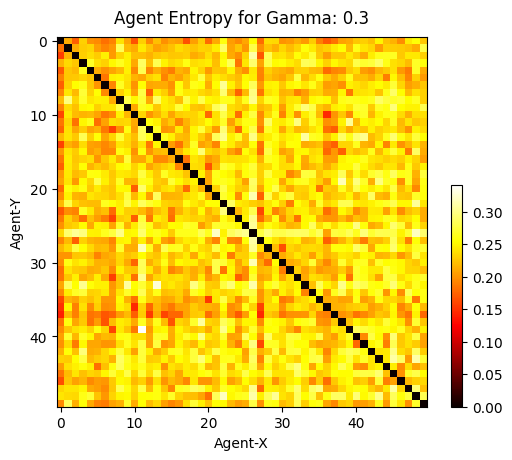

In [91]:


plt.imshow(agents_kl_divergence, cmap='hot', interpolation='nearest')
plt.title(label=f'Agent Entropy for Gamma: {alpha}',pad=+10)
plt.ylabel('Agent-Y')
plt.xlabel('Agent-X')
plt.colorbar(shrink=0.6, anchor=(0.0, 0.0))

# Display the plot
plt.show()

### Average Return per Setting

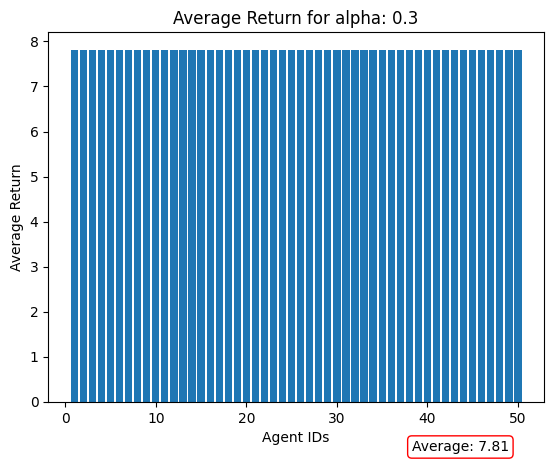

In [232]:
average_return_per_setting = []
for agent in range(1,agents_per_setting+1):
    returnlist = np.load(f'{training_folder}/agents_for_alpha_{alpha}/agent_evaluation_return_{agent}.npy')
    average_return_per_setting.append(returnlist.mean())
    
average = np.mean(average_return_per_setting)
    
# Generate x-values as integers in the range of the length of the list
AgentIDs = range(1,len(average_return_per_setting)+1)

# Create the bar chart
plt.bar(AgentIDs, average_return_per_setting)

# Set the labels and title
plt.xlabel('Agent IDs')
plt.ylabel('Average Return')
plt.title(f'Average Return for alpha: {alpha}')
plt.text(len(average_return_per_setting)-1, -1, f'Average: {average:.2f}', ha='right', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='red'))

# Show the plot
plt.show()

In [191]:
seeds = np.load('seeds.npy')
print(len(seeds))

1000


In [214]:
Agent = QLAgent(env, alpha, gamma, epsilon, epsilon_decay_rate, epsilon_min, 1500, max_steps)
return_list, reward_per_step = Agent.train()
Return = []
for seed in seeds:
    Return.append(Agent.evaluate(seed=seed))
    

100%|██████████| 1500/1500 [00:04<00:00, 327.05it/s]


In [215]:
print(np.mean(Return))

6.709


In [5]:
column_names = [x for x in range(1,Agent.max_steps+1)]
column_names.append('Argmax_Return')
df = pd.DataFrame(arr, columns=column_names)